In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
import pickle

from functions.build_constant_network import build_network
from functions.multiple_bar_plot import multiple_bar_plot

PATH = '/home/claudia/Dokumente/Uni/lab_rotation_TU/compare_AER_AEUR'

### Initialize Networks

In [2]:
AER_file = PATH + '/network_params/AER_finetuned_params_complete.p'
AER_params = pickle.load(open(AER_file, 'rb'))

AEUR_file = PATH + '/network_params/AEUR_finetuned_params_complete.p'
AEUR_params = pickle.load(open(AEUR_file, 'rb'))
   
W_AER = AER_params['weights_incl_softmax']
B_AER = AER_params['bias_incl_softmax']

W_AEUR = AEUR_params['weights_incl_softmax']
B_AEUR = AEUR_params['bias_incl_softmax']
    
x_AER, y_AER, weights_AER, bias_AER, activations_AER, measures_AER = \
build_network(W_AER, B_AER) 

x_AEUR, y_AEUR, weights_AEUR, bias_AEUR, activations_AEUR, measures_AEUR =  \
build_network(W_AEUR, B_AEUR) 

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
    

### Load data

In [3]:
DATA = pickle.load(open(PATH +'/datasets/rotated_mnist_test.p', 'rb'))
mnist = DATA['mnist']
mnist_30 = DATA['mnist_30']
mnist_60 = DATA['mnist_60']
mnist_90 = DATA['mnist_90']

DIGIT_IDX = pickle.load(open(PATH +'/datasets/mnist_test_digit_indices.p', 'rb'))
LABELS= pickle.load(open(PATH +'/datasets/mnist_test_lables.p', 'rb'))

#### Definition of a function to claculate spike-triggered average for neurons in the softmax layer

For given network, layer, one neuron within the layer and dataset (and a list of inidces from the dataset to not always use the first n) the function spike_triggered_average calculates the activations of all neurons in the layer. An image is added to the STA if for this image the selected neuron was maximally active compared to all other neurons in the layer. 

I chose this approach as opposed to setting a threshold since the activities in the softmax layer are generally low: 

In [4]:
def spike_triggered_average(layer, idx, neuron = 2, network = 'AER', \
                            dataset = 'mnist'): 
    
    samples = len(idx)
    
    if network == 'AER': 
        y = sess.run(layer, feed_dict={x_AER: DATA[dataset][idx].T, y_AER: LABELS[idx].T})
    elif network == 'AEUR': 
        y = sess.run(layer, feed_dict={x_AEUR: DATA[dataset][idx].T, y_AEUR: LABELS[idx].T})
    
    im = np.zeros((28,28))    

    for i in range(samples):
        if np.argmax(y[:, i]) == neuron: 
            im += np.reshape(DATA[dataset][idx[i]], (28, 28))

    return im

#### Calculate and plot spike triggered average for all softmax neurons in both networks and all 4 datasets

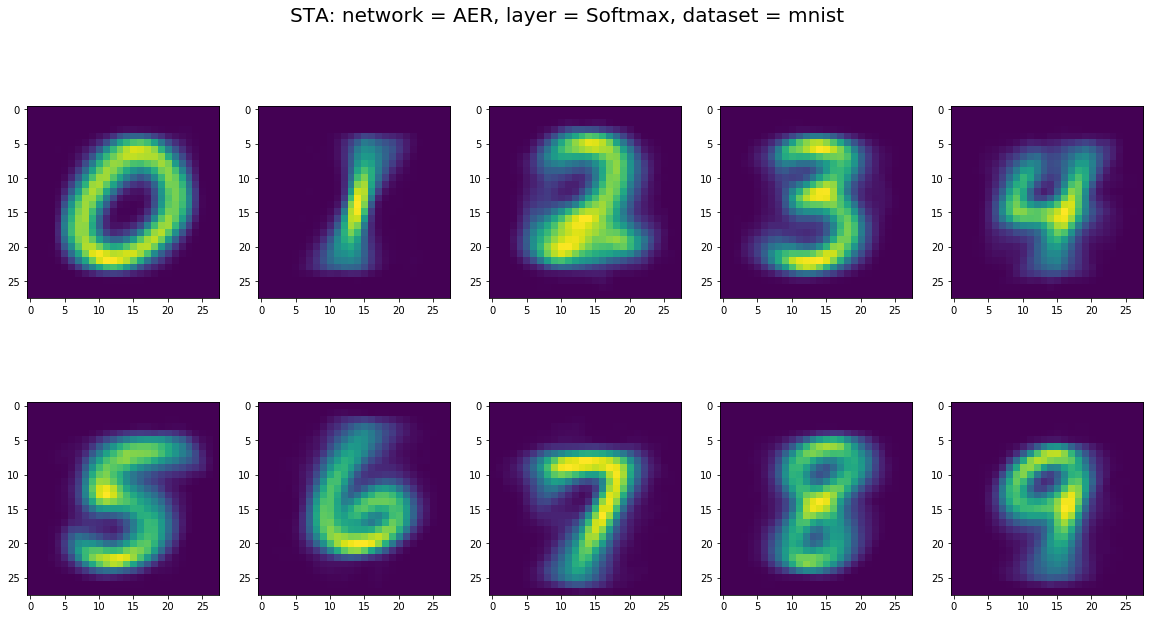

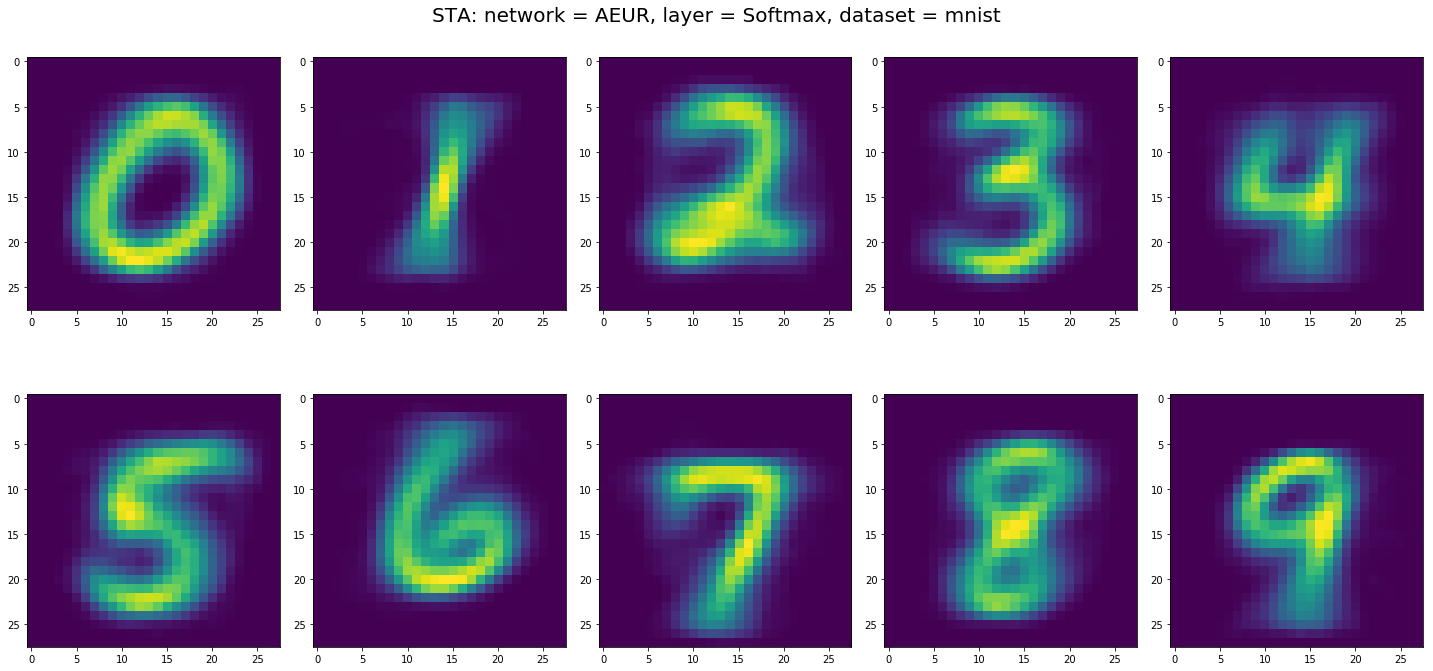

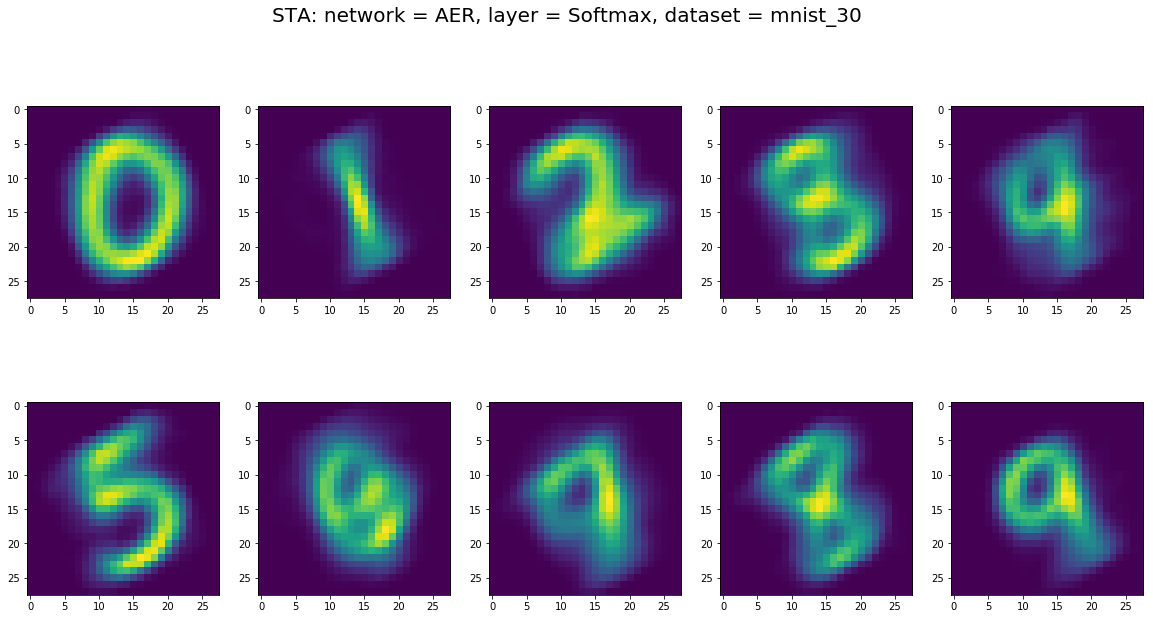

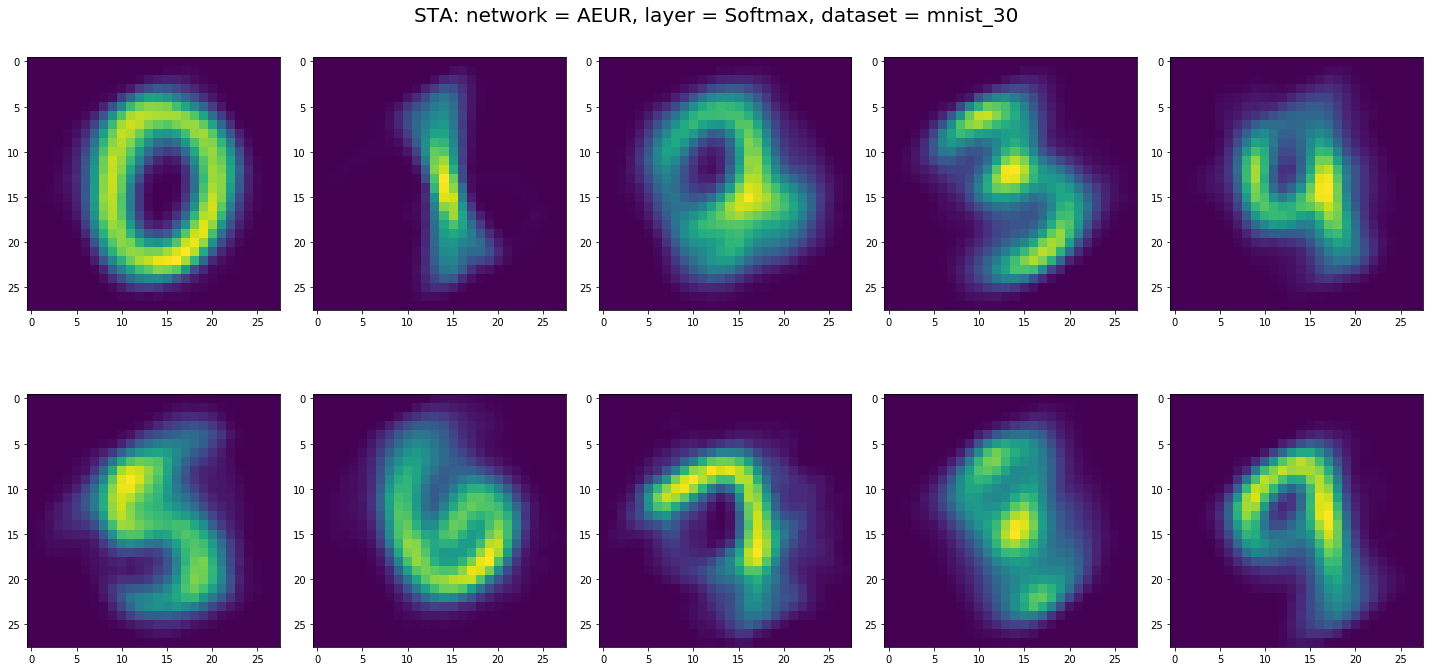

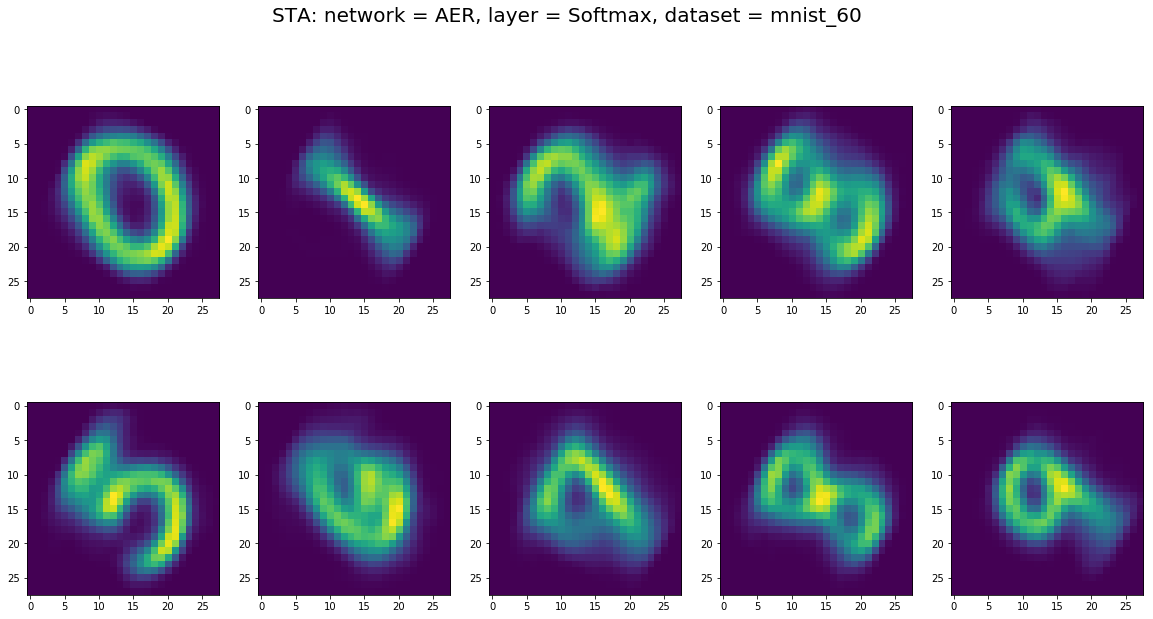

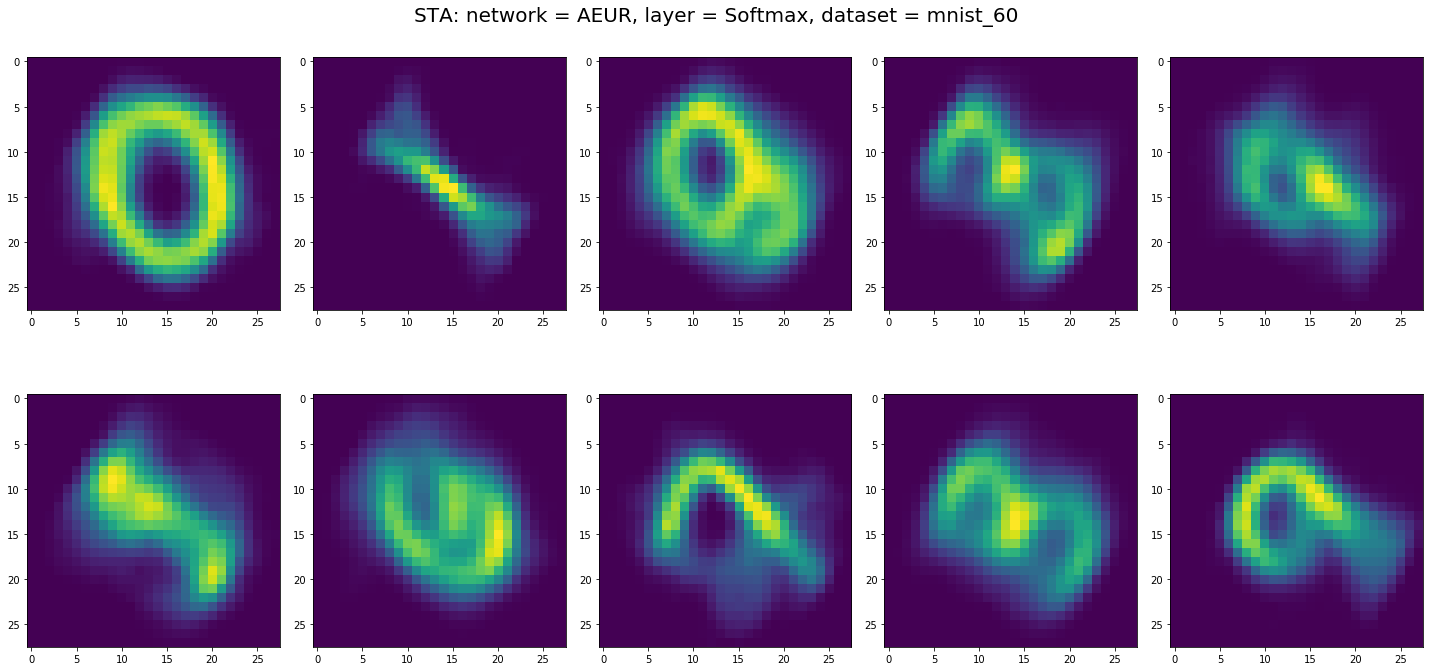

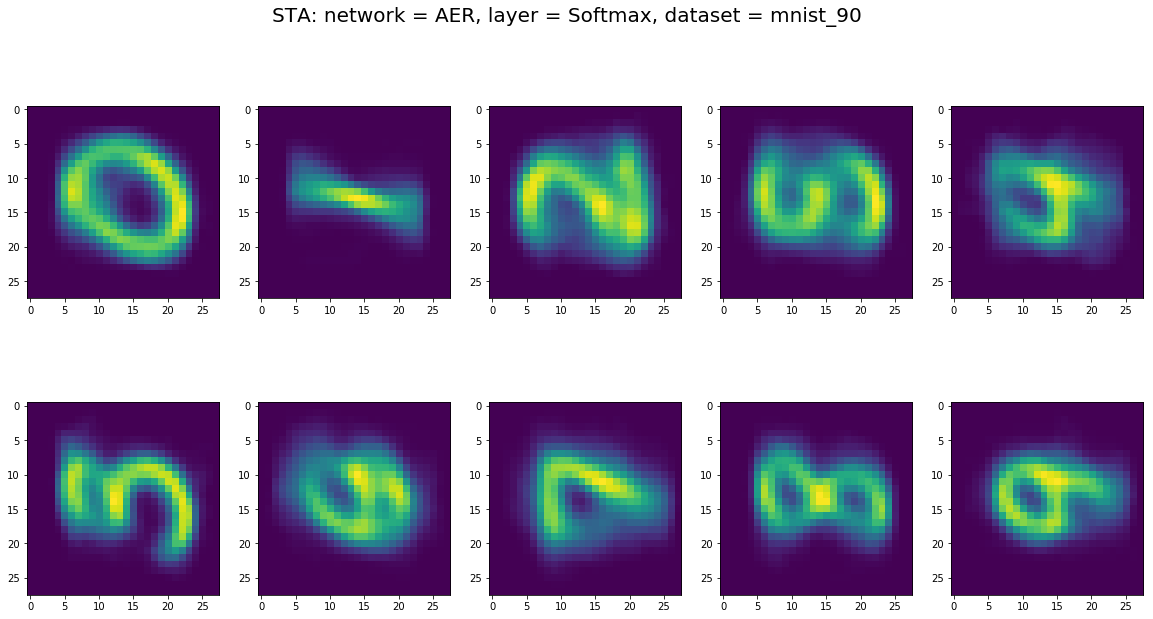

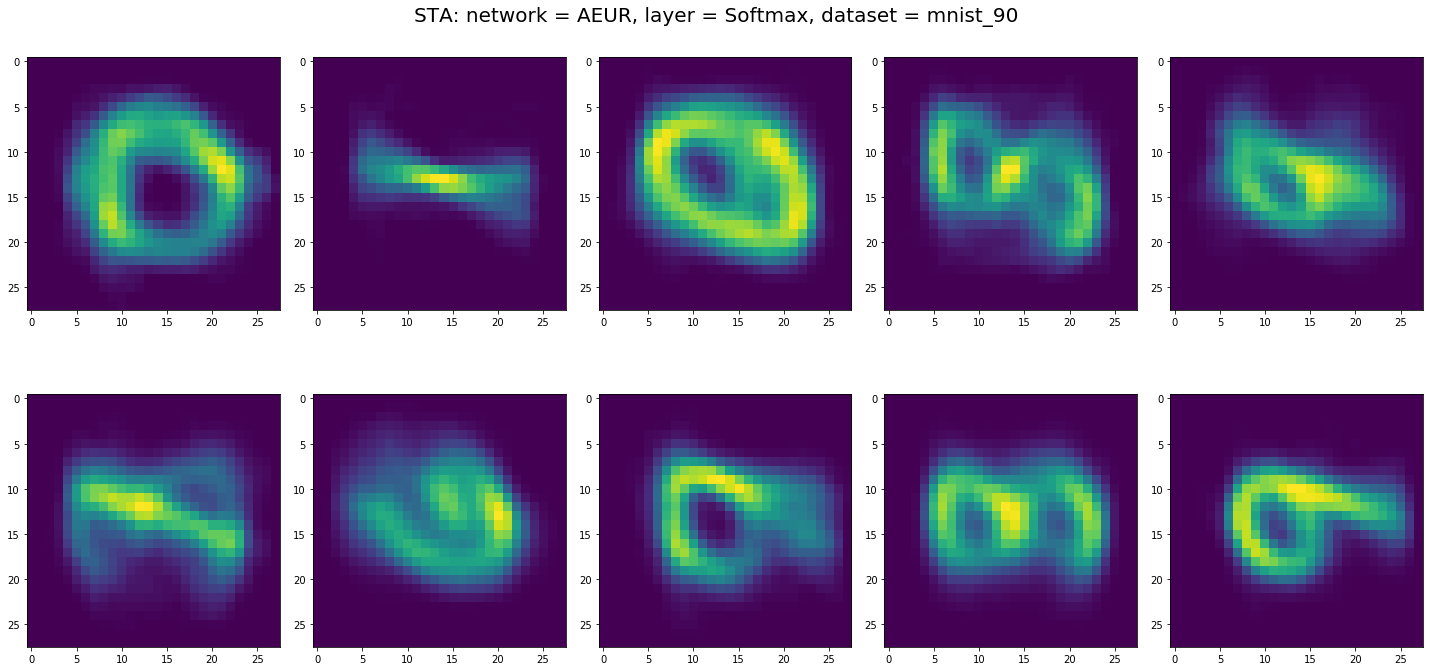

In [5]:
idx = np.random.randint(0, high = 10000, size = 5000)
datasets = ['mnist', 'mnist_30', 'mnist_60', 'mnist_90']

for d in datasets: 
    
    plt.figure(figsize = (20, 10))
    plt.suptitle('STA: network = AER, layer = Softmax, dataset = '+ d, size = 20)
    lay = activations_AER['y_']

    for i in range(10): 
        im = spike_triggered_average(lay, idx, neuron = i, network = 'AER', dataset = d)
        plt.subplot(2,5,i+1)
        plt.imshow(im)
    plt.show()


    plt.figure(figsize = (20, 10))
    plt.suptitle('STA: network = AEUR, layer = Softmax, dataset = '+ d, size = 20)
    lay = activations_AEUR['y_']

    for i in range(10): 
        im = spike_triggered_average(lay, idx,  neuron = i, network = 'AEUR', dataset = d)
        plt.subplot(2,5,i+1)
        plt.imshow(im)
    plt.tight_layout()
    plt.show()

#### Comment: 
With increasing rotation angle the Images produced with AEUR get more and more blurry. E.g. for 90 degree rotation some digits (2, 5) are not recognizable at all. 
The images created with AEUR on the other hand are still pretty clear for all rotations. 

#### Toy example showing the STA for all neurons in AER layer 4

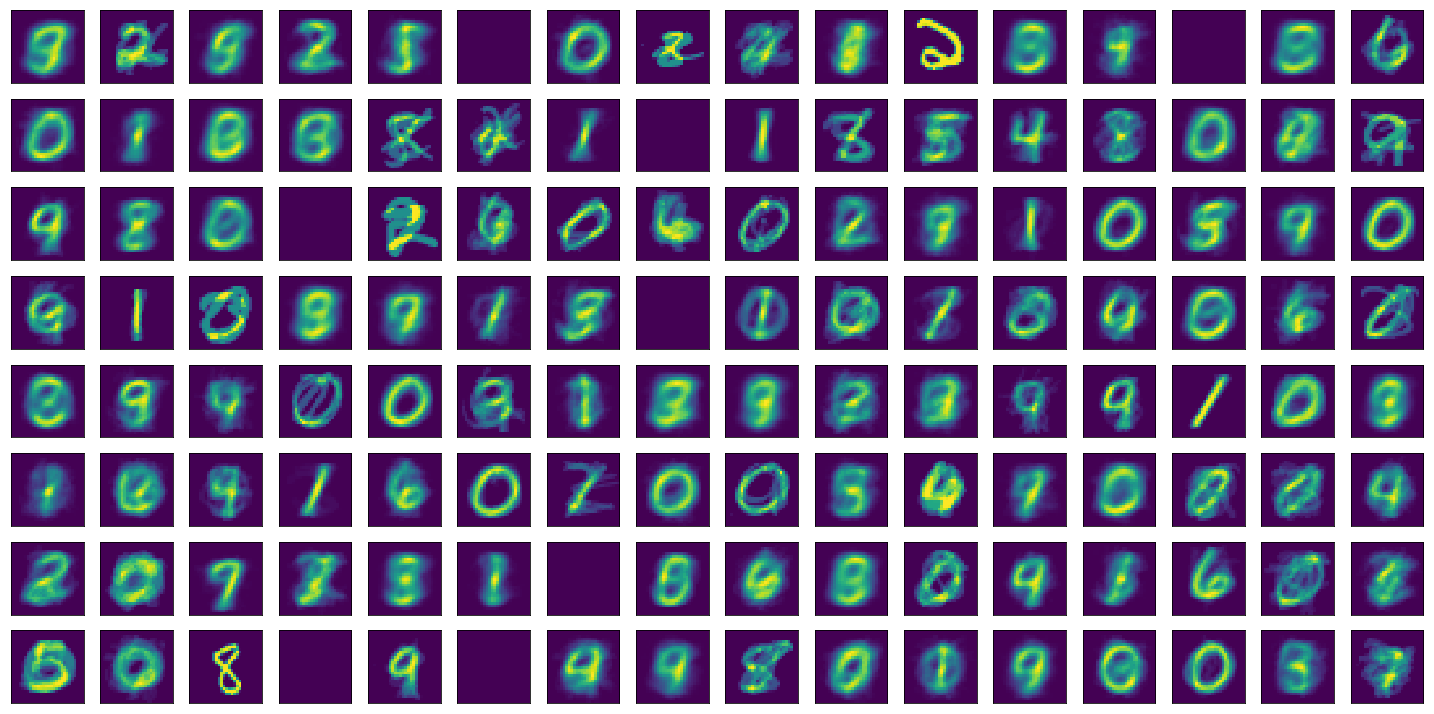

In [6]:
idx = np.random.randint(0, high = 10000, size = 5000)
layer = activations_AER['h_4']
y = sess.run(layer, feed_dict={x_AER: DATA['mnist'][idx].T, y_AER: LABELS[idx].T})

plt.figure(figsize= (20, 10))
for n in range(128): 
    im = np.zeros((28, 28))
    for s in range(1000): 
        if y[n, s] > .9: 
            im += np.reshape(DATA['mnist'][idx[s]], (28, 28))
    plt.subplot(8, 16, n+1) 
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
#plt.savefig('STA_AER_lay4_deg0_all' + '.jpg')
    

### Invariant neurons:

__Idea:__ if neuron n is activated by the same digit whether or not this digit was rotated, then the relevant neuron is rotation invariant. 

In [7]:
import scipy
from scipy.stats import mode

idx = idx.copy()
layer = activations_AEUR['h_4']

y_mnist = sess.run(layer, feed_dict={x_AEUR: DATA['mnist'][idx].T, y_AEUR: LABELS[idx].T})
y_mnist_90 = sess.run(layer, feed_dict={x_AEUR: DATA['mnist_90'][idx].T, y_AEUR: LABELS[idx].T})


for n in range(128):
    y_mnist_favs = []
    y_mnist_90_favs = []
    for s in range(1000): 
        if y_mnist[n, s] > .9: 
            y_mnist_favs.append(np.argmax(LABELS[s]))
        if y_mnist_90[n, s] > .9: 
            y_mnist_90_favs.append(np.argmax(LABELS[s]))
    
    m, c = mode(y_mnist_favs)
    l = len(y_mnist_favs)
     
    m90, c90 = mode(y_mnist_90_favs)
    l90 = len(y_mnist_90_favs)
    
        
    if (len(c) != 0 ) and float(c[0])/l > .3 and (len(c90) != 0 ) \
            and float(c90[0])/l > .3 and m[0] == m90[0]: 
        print(np.bincount(y_mnist_favs))
        print('0 - neuron', n, 'acts >.9:', l, 'mode:', m[0], 'count:', c[0])
        print(np.bincount(y_mnist_90_favs))
        print('90 - neuron', n, 'acts >.9:', l90, 'mode:', m90[0], 'count:', c90[0])
        print('\n')

[0 3 2 0 0 0 1 1]
0 - neuron 13 acts >.9: 7 mode: 1 count: 3
[ 6 17  9 12 12  6  7 11  3  9]
90 - neuron 13 acts >.9: 92 mode: 1 count: 17


[1 0 3 0 1 1 1 1 1]
0 - neuron 33 acts >.9: 9 mode: 2 count: 3
[12 19 23 15 12 10 11 16 11 13]
90 - neuron 33 acts >.9: 142 mode: 2 count: 23


[1 1 5 1 1 0 3 0 0 1]
0 - neuron 46 acts >.9: 13 mode: 2 count: 5
[ 5  4 17  9  4  3  5  6 12  8]
90 - neuron 46 acts >.9: 73 mode: 2 count: 17


[0 0 0 1 0 0 0 2 1]
0 - neuron 64 acts >.9: 4 mode: 7 count: 2
[ 5  9  7 11 10 10  3 12  8  8]
90 - neuron 64 acts >.9: 83 mode: 7 count: 12


[0 0 1 1 0 0 0 0 0 1]
0 - neuron 84 acts >.9: 3 mode: 2 count: 1
[ 6  6 10  7  7  2  6  1  2  4]
90 - neuron 84 acts >.9: 51 mode: 2 count: 10


[0 1 0 0 0 0 0 0 1]
0 - neuron 109 acts >.9: 2 mode: 1 count: 1
[10 14  9 11 11  5 11 13  5 10]
90 - neuron 109 acts >.9: 99 mode: 1 count: 14




__Comment:__A lot more high activations for the roatated dataset but not very specific

In [8]:
def no_invar_neurons(lay, tol = .4):
    netw_names = ['AER', 'AEUR']
    invar_neurons = {'AER' : np.zeros(10), 'AEUR': np.zeros(10)}

    for nets in range(2): 
        if nets == 0: 
            layer = activations_AER[lay]
            y_mnist = sess.run(layer, feed_dict={x_AER: DATA['mnist'].T, y_AER: LABELS.T})
            y_mnist_90 = sess.run(layer, feed_dict={x_AER: DATA['mnist_90'].T, y_AER: LABELS.T})

        if nets == 1: 
            layer = activations_AEUR[lay]
            y_mnist = sess.run(layer, feed_dict={x_AEUR: DATA['mnist'].T, y_AEUR: LABELS.T})
            y_mnist_90 = sess.run(layer, feed_dict={x_AEUR: DATA['mnist_90'].T, y_AEUR: LABELS.T})

        for n in range(len(y_mnist)):
        # for each neuron and both datasets we save all the digits that cause 
        # a high activation 
            y_mnist_favs = []
            y_mnist_90_favs = []
            for s in range(1000): 
                if y_mnist[n, s] > .9: 
                    y_mnist_favs.append(np.argmax(LABELS[s]))
                if y_mnist_90[n, s] > .9: 
                    y_mnist_90_favs.append(np.argmax(LABELS[s]))
            # the mode is the digit that caused above threshold activation most of the times       
            m, c = mode(y_mnist_favs) 
            l = len(y_mnist_favs)

            m90, c90 = mode(y_mnist_90_favs)
            l90 = len(y_mnist_90_favs)

            if (len(c) != 0 ) and float(c[0])/l > tol and (len(c90) != 0 ) \
            and float(c90[0])/l > tol and m[0] == m90[0]: 
            # if a neuron is repeadedly activated by the same digit wheter or not this 
            # digit is rotated we say this neuron is rotation invaraiant. (The neuron is only 
            # saved if the relevant digit is responsible for at least 30% of the high 
            #activations)  
                invar_neurons[netw_names[nets]][m[0]] += 1
                
    return invar_neurons

In [9]:
invar_neurons_layer4 = no_invar_neurons('h_4', tol = .3)


In [10]:
invar_neurons_layer3 = no_invar_neurons('h_3', tol = .3)

In [11]:
invar_neurons_layer2 = no_invar_neurons('h_2', tol = .3)

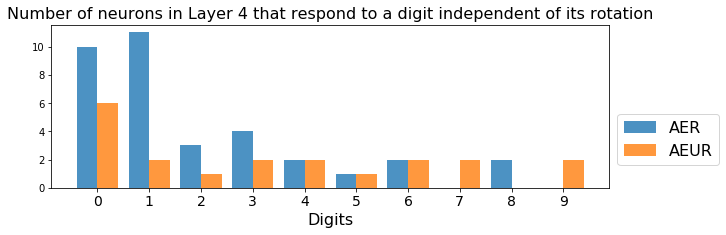

In [12]:
fig = plt.figure(figsize = (10, 3))
netw_names = ['AER', 'AEUR']
invar = [invar_neurons_layer4['AER'], invar_neurons_layer4['AEUR']]
x_ticks = np.arange(0,10,1)
title = 'Number of neurons in Layer 4 that respond to a digit independent of its rotation'
multiple_bar_plot(invar, np.arange(0,10,1), netw_names, title, height_label = False,\
                  x_ticks = x_ticks, fig = fig, x_label = 'Digits')

The above plot shows for each digit how many layer 4 neurons show an activation higher than .9 when presented with this digit. I only count neurons that express a considerable preference for the given digit, ie. at least 30% of the activations above .9 must be caused by this digit (in the rotated and the unrotated case). 




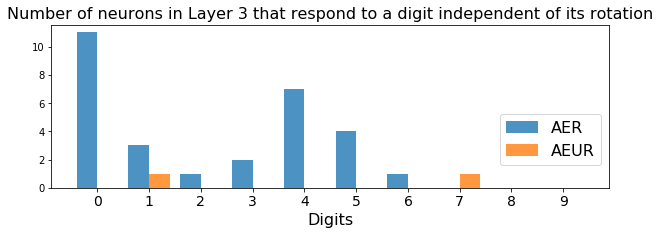

In [13]:
fig = plt.figure(figsize = (10, 3))
invar = [invar_neurons_layer3['AER'], invar_neurons_layer3['AEUR']]
x_ticks = np.arange(0,10,1)
title = 'Number of neurons in Layer 3 that respond to a digit independent of its rotation'
multiple_bar_plot(invar, np.arange(0,10,1), netw_names, title, height_label = False,\
                  x_ticks = x_ticks, fig = fig, x_label = 'Digits')

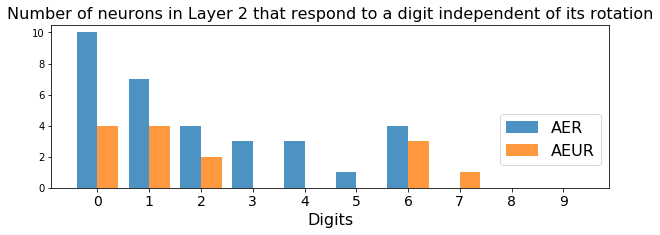

In [14]:
fig = plt.figure(figsize = (10, 3))
invar = [invar_neurons_layer2['AER'], invar_neurons_layer2['AEUR']]
x_ticks = np.arange(0,10,1)
title = 'Number of neurons in Layer 2 that respond to a digit independent of its rotation'
multiple_bar_plot(invar, np.arange(0,10,1), netw_names, title, height_label = False,\
                  x_ticks = x_ticks, fig = fig, x_label = 'Digits')

#### Comment: 
For all layers and digits the AER appears to have significantly more invaraiant neurons than  the AEUR network.


The plot below shows which neurons in layer 4 (AER) show maxiaml activity when classifying 1s s. (This is investigated further in 'knock out neurons'- notebook)

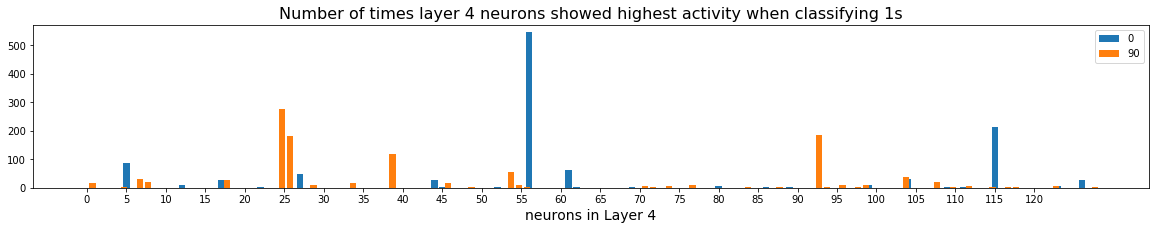

In [18]:
# chnges AUR to AER
ones_unrot = mnist[DIGIT_IDX['only_1']]
ones_90 = mnist_90[DIGIT_IDX['only_1']]

layer = activations_AEUR['h_4']
y_ones_0 = sess.run(layer, feed_dict={x_AEUR: ones_unrot.T, y_AEUR: LABELS[DIGIT_IDX['only_1']].T})
y_ones_90 = sess.run(layer, feed_dict={x_AEUR: ones_90.T, y_AEUR: LABELS[DIGIT_IDX['only_1']].T})

z_0 = np.argmax(y_ones_0, axis = 0)
zz_0 = np.bincount(z_0)

z_90 = np.argmax(y_ones_90, axis = 0)
zz_90 = np.bincount(z_90)
rot_neurons = np.flatnonzero(zz_90)


plt.figure(figsize = (20, 3))
plt.bar(np.arange(0,127, 1), zz_0, label = '0')
plt.bar(np.arange(0,128, 1)+.7, zz_90, label = '90')
plt.xticks(np.arange(0,125, 5))
plt.xlabel('neurons in Layer 4', size =14)
plt.title('Number of times layer 4 neurons showed highest activity when classifying 1s', size = 16)
plt.legend()
plt.show()

#### Finally the two plots below show how often neurons in layer 4 and layer 3 were activated above.95

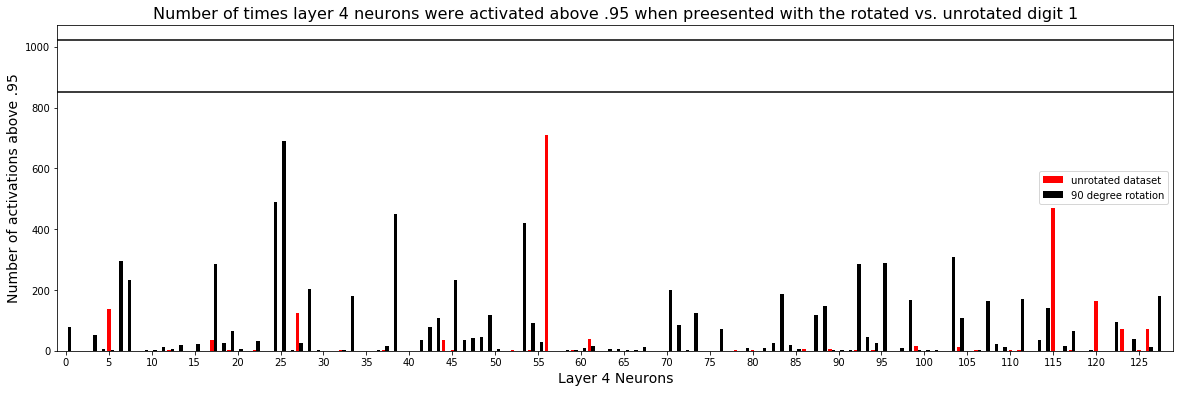

In [19]:
thresh = .95
n = len(ones_unrot)

y_ones_0[y_ones_0 < thresh] = 0.
y_ones_0[y_ones_0 >= thresh] = 1.
a_0 = np.sum(y_ones_0, axis = 1).astype(int)

y_ones_90[y_ones_90 < thresh] = 0.
y_ones_90[y_ones_90 >= thresh] = 1.
a_90 = np.sum(y_ones_90, axis = 1).astype(int)

plt.figure(figsize = (20, 6))
plt.bar(np.arange(0,128, 1), a_0, .4, color = 'red', label = 'unrotated dataset')
plt.bar(np.arange(0,128, 1) + .4, a_90, .4, color = 'black', label = '90 degree rotation')
plt.plot([-1, 129], [n*.75, n*.75], 'k-')
plt.plot([-1, 129], [n*.9, n*.9], 'k-')

plt.xticks(np.arange(0, 130, 5))
plt.xlabel('Layer 4 Neurons', size = 14)
plt.ylabel('Number of activations above .95', size = 14)
plt.xlim(-1, 129)
plt.title('Number of times layer 4 neurons were activated above .95 when \
preesented with the rotated vs. unrotated digit 1', size = 16)
plt.legend()
plt.show()

The black horizonatal lines indicate 75 and 90% of the ones- dataset

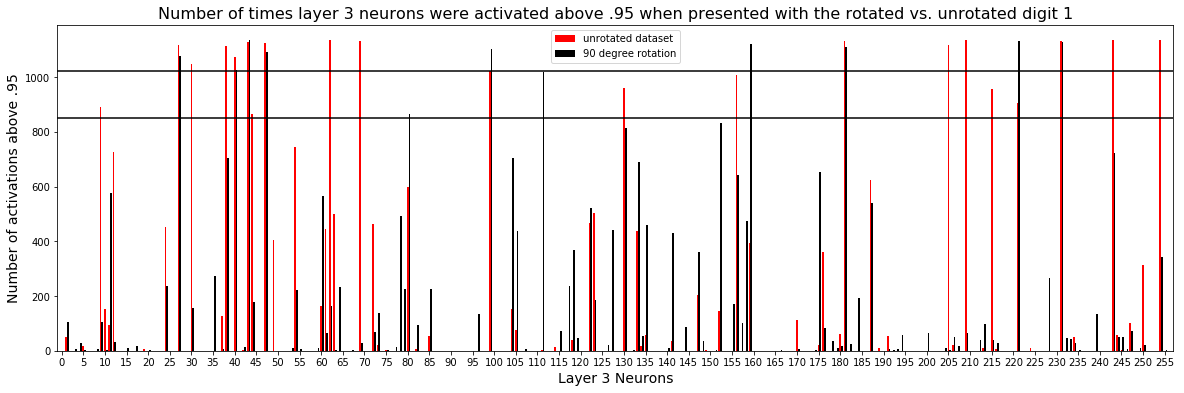

In [20]:
layer = activations_AER['h_3']
y_ones_0_3 = sess.run(layer, feed_dict={x_AER: ones_unrot.T, y_AER: LABELS[DIGIT_IDX['only_1']].T})
y_ones_90_3 = sess.run(layer, feed_dict={x_AER: ones_90.T, y_AER: LABELS[DIGIT_IDX['only_1']].T})

y_ones_0_3[y_ones_0_3 < thresh] = 0.
y_ones_0_3[y_ones_0_3 >= thresh] = 1.
a_0_3 = np.sum(y_ones_0_3, axis = 1).astype(int)

y_ones_90_3[y_ones_90_3 < thresh] = 0.
y_ones_90_3[y_ones_90_3 >= thresh] = 1.
a_90_3 = np.sum(y_ones_90_3, axis = 1).astype(int)

plt.figure(figsize = (20, 6))
plt.bar(np.arange(0,256, 1), a_0_3, .4, color = 'red', label = 'unrotated dataset')
plt.bar(np.arange(0,256, 1) + .4, a_90_3, .4, color = 'black', label = '90 degree rotation')
plt.plot([-1, 257], [n*.75, n*.75], 'k-')
plt.plot([-1, 257], [n*.9, n*.9], 'k-')

plt.xticks(np.arange(0, 260, 5))
plt.xlabel('Layer 3 Neurons', size = 14)
plt.ylabel('Number of activations above .95', size = 14)
plt.xlim(-1, 257)
plt.title('Number of times layer 3 neurons were activated above .95 when \
presented with the rotated vs. unrotated digit 1', size = 16)
plt.legend()
plt.show()
